In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

a_coeff = 1 # 2 1 1
b_coeff = 1 # 1 2 1
mu_coeff = 1 # 1 1 2
f = lambda x, y, t: np.sin(x) * np.sin(y) * (mu_coeff * np.cos(mu_coeff * t) + (a_coeff + b_coeff) * np.sin(mu_coeff * t))

alpha1 = 0
beta1 = 1
gamma1 = lambda y, t: 0

alpha2 = 0
beta2 = 1
gamma2 = lambda y, t: np.sin(y) * np.sin(mu_coeff * t)

alpha3 = 0
beta3 = 1
gamma3 = lambda x, t: 0

alpha4 = 1
beta4 = 0
gamma4 = lambda x, t: -np.sin(x) * np.sin(mu_coeff * t)

psi = lambda x, y: 0

analytical_solution = lambda x, y, t: np.sin(x) * np.sin(y) * np.sin(mu_coeff * t)

hx = 0.05
hy = 0.05
tau = 0.05
tau2 = tau / 2

Lx = np.pi / 2
Ly = np.pi
T_max = 1

X = np.arange(0, Lx + hx / 2, hx)
Y = np.arange(0, Ly + hy / 2, hy)
T = np.arange(0, T_max + tau2 / 2, tau2)

def solve_alternating_directions():
    u_num = np.zeros((len(X), len(Y), len(T)))
    u_num[:, :, 0] = psi(X, Y) 

    N = len(X) - 1
    M = len(Y) - 1

    for k in range(0, len(T) - 1, 2):
        u_prev = u_num[:, :, k]
        u_next = np.zeros_like(u_prev)
        
        # Заполняем t^(k + 1/2)      
        
        A = np.zeros((len(X), len(Y)))
        B = np.zeros((len(X), len(Y)))
        C = np.zeros((len(X), len(Y)))
        D = np.zeros((len(X), len(Y)))
        
        for i in range(1, N):
            for j in range(1, M):
                A[i, j] = -a_coeff / hx ** 2
                B[i, j] = 2 / tau + 2 * a_coeff / hx ** 2
                C[i, j] = -a_coeff / hx ** 2
                D[i, j] = f(X[i], Y[j], T[k + 1]) + b_coeff / hy ** 2 * (
                    u_prev[i, j + 1] - 2 * u_prev[i, j] + u_prev[i, j - 1]
                ) + 2 * u_prev[i, j] / tau
        
        
        # Граничные условия (3 точки 2й порядок)
        print("1: ", C[1, :], C.shape)
        coeff1 = (-alpha1 / 2 / hx) / C[1, :]
        A[0, :] = 0
        B[0, :] = (alpha1 * (-3 / 2 / hx) + beta1) - A[1, :] * coeff1
        C[0, :] = (alpha1 * (4 / 2 / hx)) - B[1, :] * coeff1
        D[0, :] = gamma1(Y, T[k + 1]) - D[1, :] * coeff1
        
        coeff2 = (alpha2 / 2 / hx) / A[N - 1, :]
        A[N, :] = -alpha2 * (4 / 2 / hx) - B[N - 1, :] * coeff2
        B[N, :] = alpha2 * (3 / 2 / hx) + beta2 - C[N - 1, :] * coeff2
        C[N, :] = 0
        D[N, :] = gamma2(Y, T[k + 1]) - D[N - 1, :] * coeff2
        
        A[:, 0] = 0
        B[:, 0] = beta3 - alpha3 / hy
        C[:, 0] = alpha3 / hy
        D[:, 0] = gamma3(X, T[k + 1])
        
        A[:, M] = alpha4 / hy
        B[:, M] = beta4 + alpha4 / hy
        C[:, M] = 0
        D[:, M] = gamma4(X, T[k + 1])
        
        # Метод прогонки
        alpha_prop = np.zeros((len(X), len(Y)))
        beta_prop = np.zeros((len(X), len(Y)))
        
        if np.all(abs(B[0, :])) < 1e-12:
            raise ValueError("Деление на ноль в методе прогонки")
        
        alpha_prop[0, :] = -C[0, :] / B[0, :]
        beta_prop[0, :] = D[0, :] / B[0, :]
        
        for i in range(1, len(X)):
            denominator = B[i, :] + A[i, :] * alpha_prop[i - 1, :]
            if np.all(abs(denominator)) < 1e-12:
                raise ValueError("Деление на ноль в методе прогонки")
            if i < N:
                alpha_prop[i, :] = -C[i, :] / denominator
            beta_prop[i, :] = (D[i, :] - A[i, :] * beta_prop[i - 1, :]) / denominator
            
        u_next[N, :] = beta_prop[N, :]
        
        for i in range(N - 1, -1, -1):
            u_next[i, :] = alpha_prop[i, :] * u_next[i + 1, :] + beta_prop[i, :]
        
        u_num[:, :, k + 1] = u_next
        
        # Заполняем t^(k + 1)
        u_prev = u_num[:, :, k + 1]
        u_next = np.zeros_like(u_prev)
        
        A = np.zeros((len(X), len(Y)))
        B = np.zeros((len(X), len(Y)))
        C = np.zeros((len(X), len(Y)))
        D = np.zeros((len(X), len(Y)))
        
        for j in range(1, M):
            for i in range(1, N):
                A[i, j] = -b_coeff / hy ** 2
                B[i, j] = 2 / tau + 2 * b_coeff / hy ** 2
                C[i, j] = -b_coeff / hy ** 2
                D[i, j] = f(X[i], Y[j], T[k + 1]) + a_coeff / hx ** 2 * (
                    u_prev[i + 1, j] - 2 * u_prev[i, j] + u_prev[i - 1, j]
                ) + 2 * u_prev[i, j] / tau
        
        A[0, :] = 0
        B[0, :] = beta1 - alpha1 / hx
        C[0, :] = alpha1 / hx
        D[0, :] = gamma1(Y, T[k + 2])
        
        A[N, :] = -alpha2 / hx
        B[N, :] = beta2 + alpha2 / hx
        C[N, :] = 0
        D[N, :] = gamma2(Y, T[k + 2])
        
        A[:, 0] = 0
        B[:, 0] = beta3 - alpha3 / hy
        C[:, 0] = alpha3 / hy
        D[:, 0] = gamma3(X, T[k + 2])
        
        A[:, M] = alpha4 / hy
        B[:, M] = beta4 + alpha4 / hy
        C[:, M] = 0
        D[:, M] = gamma4(X, T[k + 2])
        
        # Метод прогонки
        alpha_prop = np.zeros((len(X), len(Y)))
        beta_prop = np.zeros((len(X), len(Y)))
        
        if np.all(abs(B[:, 0])) < 1e-12:
            raise ValueError("Деление на ноль в методе прогонки")
        
        alpha_prop[:, 0] = -C[:, 0] / B[:, 0]
        beta_prop[:, 0] = D[:, 0] / B[:, 0]
        
        for j in range(1, len(Y)):
            denominator = B[:, j] + A[:, j] * alpha_prop[:, j - 1]
            if np.all(abs(denominator)) < 1e-12:
                raise ValueError("Деление на ноль в методе прогонки")
            if j < M:
                alpha_prop[:, j] = -C[:, j] / denominator
            beta_prop[:, j] = (D[:, j] - A[:, j] * beta_prop[:, j - 1]) / denominator
            
        u_next[:, M] = beta_prop[:, M]
        
        for j in range(M - 1, -1, -1):
            u_next[:, j] = alpha_prop[:, j] * u_next[:, j + 1] + beta_prop[:, j]
        
        u_num[:, :, k + 2] = u_next
        
    return u_num
 

1:  [   0. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400.    0.] (32, 64)
1:  [   0. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400.    0.] (32, 64)
1:  [   0. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400.

/tmp/ipykernel_121724/3322655142.py:73: RuntimeWarning: invalid value encountered in divide
  coeff1 = (-alpha1 / 2 / hx) / C[1, :]
/tmp/ipykernel_121724/3322655142.py:79: RuntimeWarning: invalid value encountered in divide
  coeff2 = (alpha2 / 2 / hx) / A[N - 1, :]


1:  [   0. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400.    0.] (32, 64)
1:  [   0. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400.    0.] (32, 64)
1:  [   0. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400. -400.
 -400. -400. -400. -400. -400. -400. -400.

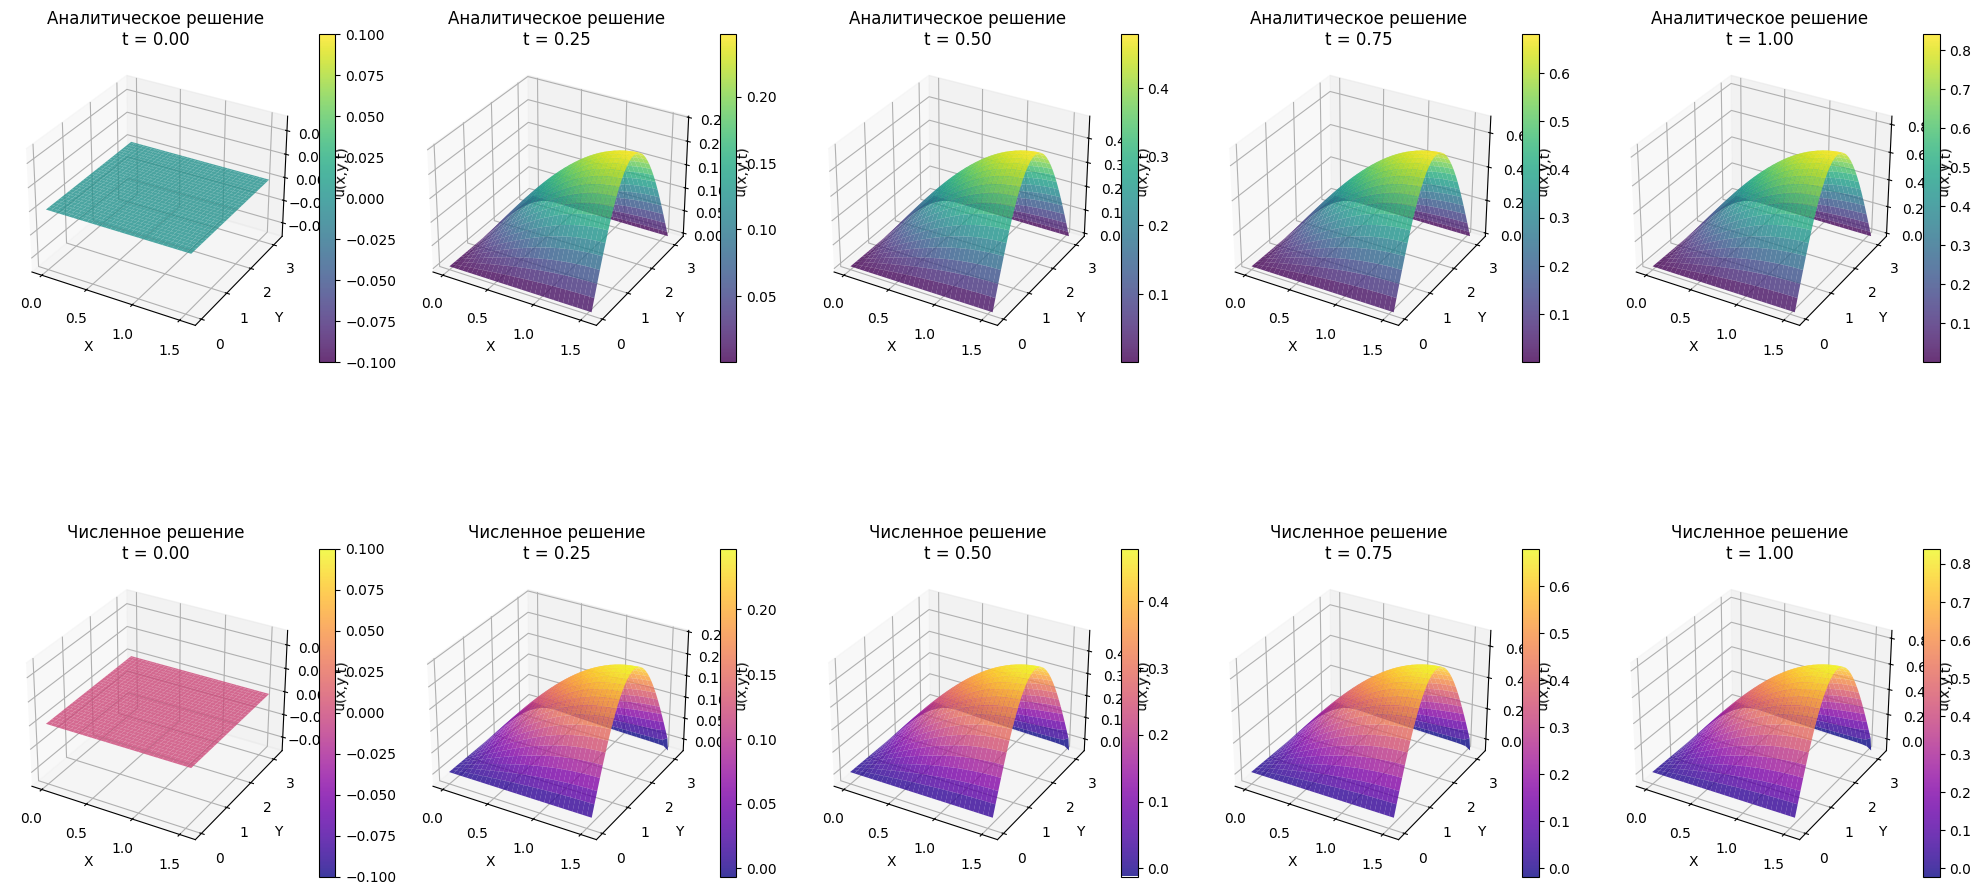

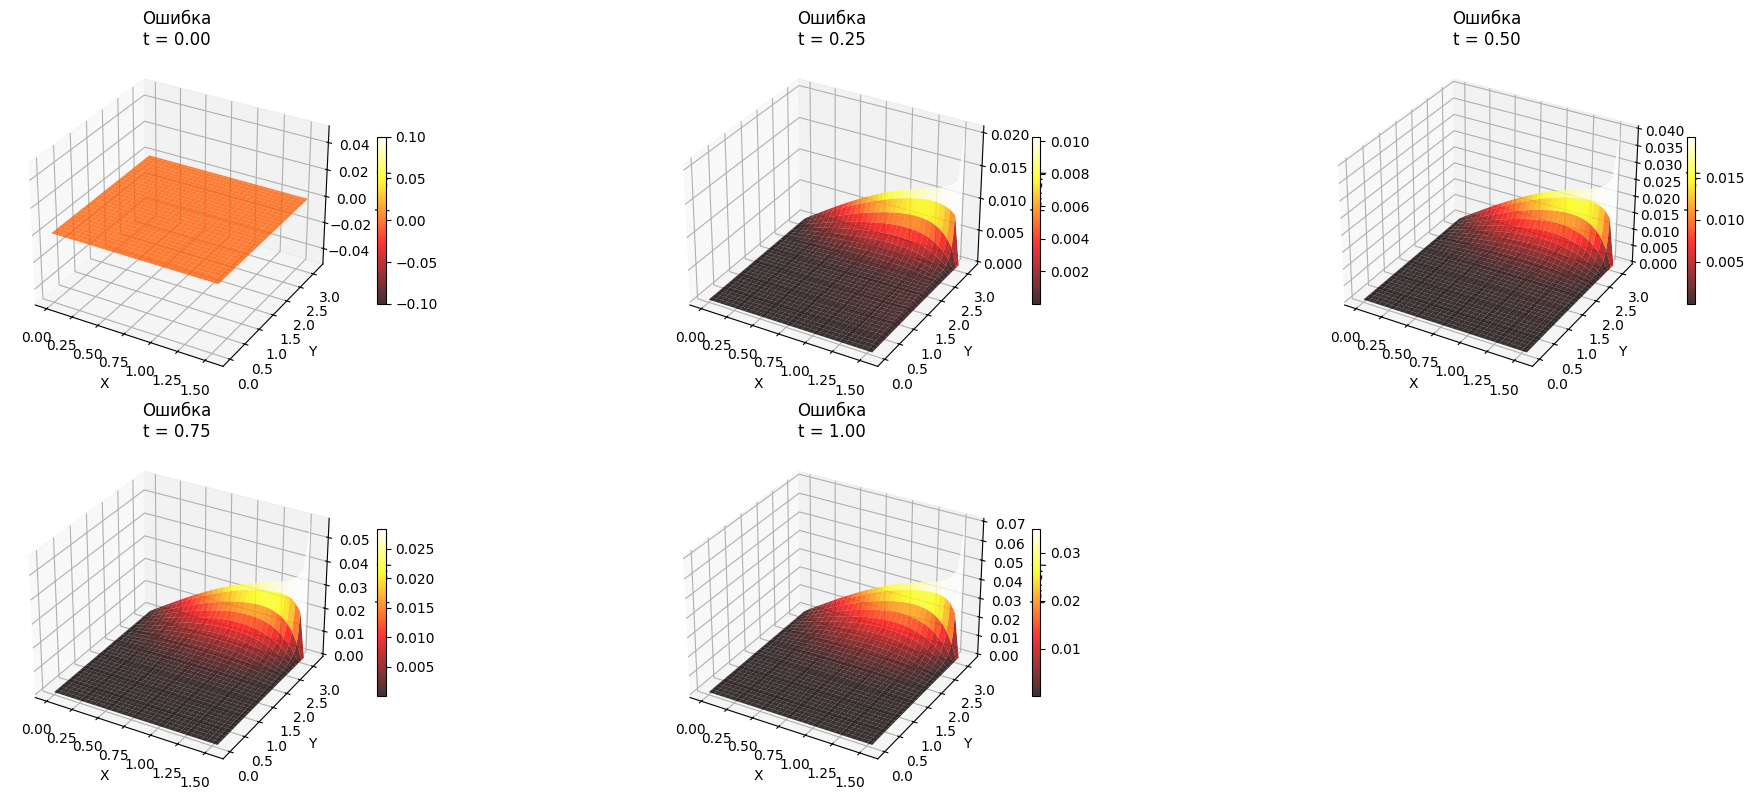

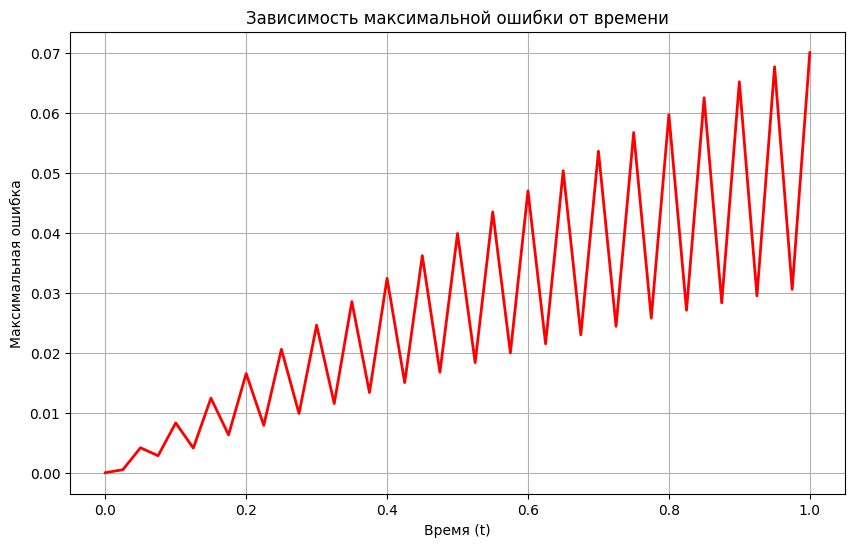

Максимальная ошибка в конечный момент времени: 6.998045e-02
Средняя ошибка в конечный момент времени: 3.002233e-03


In [2]:
u_num = solve_alternating_directions()

# Создаем сетку для построения графиков
X_grid, Y_grid = np.meshgrid(X, Y, indexing='ij')

# Выбираем моменты времени для визуализации
time_indices = [0, len(T)//4, len(T)//2, 3*len(T)//4, len(T)-1]
time_labels = [f"t = {T[i]:.2f}" for i in time_indices]

# Создаем фигуру для сравнения решений
fig = plt.figure(figsize=(20, 12))

for idx, (t_idx, t_label) in enumerate(zip(time_indices, time_labels)):
    # Аналитическое решение
    ax1 = fig.add_subplot(2, 5, idx + 1, projection='3d')
    u_analytical = analytical_solution(X_grid, Y_grid, T[t_idx])
    surf1 = ax1.plot_surface(X_grid, Y_grid, u_analytical, cmap='viridis', alpha=0.8)
    ax1.set_title(f'Аналитическое решение\n{t_label}')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('u(x,y,t)')
    fig.colorbar(surf1, ax=ax1, shrink=0.5)
    
    # Численное решение
    ax2 = fig.add_subplot(2, 5, idx + 6, projection='3d')
    surf2 = ax2.plot_surface(X_grid, Y_grid, u_num[:, :, t_idx], cmap='plasma', alpha=0.8)
    ax2.set_title(f'Численное решение\n{t_label}')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('u(x,y,t)')
    fig.colorbar(surf2, ax=ax2, shrink=0.5)

plt.tight_layout()
plt.show()

# Визуализация ошибки
fig2 = plt.figure(figsize=(20, 8))

for idx, (t_idx, t_label) in enumerate(zip(time_indices, time_labels)):
    ax = fig2.add_subplot(2, 3, idx + 1, projection='3d')
    u_analytical = analytical_solution(X_grid, Y_grid, T[t_idx])
    error = np.abs(u_num[:, :, t_idx] - u_analytical)
    surf = ax.plot_surface(X_grid, Y_grid, error, cmap='hot', alpha=0.8)
    ax.set_title(f'Ошибка\n{t_label}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('|error|')
    fig2.colorbar(surf, ax=ax, shrink=0.5)

plt.tight_layout()
plt.show()

# Анимация решений (опционально)
def create_animation():
    from matplotlib.animation import FuncAnimation
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': '3d'})
    
    def update(frame):
        for ax in [ax1, ax2]:
            ax.cla()
        
        # Аналитическое решение
        u_analytical = analytical_solution(X_grid, Y_grid, T[frame])
        surf1 = ax1.plot_surface(X_grid, Y_grid, u_analytical, cmap='viridis', alpha=0.8)
        ax1.set_title(f'Аналитическое решение\nt = {T[frame]:.2f}')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('u(x,y,t)')
        ax1.set_zlim(np.min(u_analytical), np.max(u_analytical))
        
        # Численное решение
        surf2 = ax2.plot_surface(X_grid, Y_grid, u_num[:, :, frame], cmap='plasma', alpha=0.8)
        ax2.set_title(f'Численное решение\nt = {T[frame]:.2f}')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('u(x,y,t)')
        ax2.set_zlim(np.min(u_num[:, :, frame]), np.max(u_num[:, :, frame]))
        
        return surf1, surf2
    
    anim = FuncAnimation(fig, update, frames=len(T), interval=100, blit=False)
    plt.tight_layout()
    plt.show()
    
    return anim

# Раскомментируйте следующую строку, если хотите посмотреть анимацию
# anim = create_animation()

# График максимальной ошибки по времени
max_errors = []
for t_idx in range(len(T)):
    u_analytical = analytical_solution(X_grid, Y_grid, T[t_idx])
    max_error = np.max(np.abs(u_num[:, :, t_idx] - u_analytical))
    max_errors.append(max_error)

plt.figure(figsize=(10, 6))
plt.plot(T, max_errors, 'r-', linewidth=2)
plt.xlabel('Время (t)')
plt.ylabel('Максимальная ошибка')
plt.title('Зависимость максимальной ошибки от времени')
plt.grid(True)
plt.show()

# Вывод статистики по ошибкам
final_error = np.max(np.abs(u_num[:, :, -1] - analytical_solution(X_grid, Y_grid, T[-1])))
print(f"Максимальная ошибка в конечный момент времени: {final_error:.6e}")
print(f"Средняя ошибка в конечный момент времени: {np.mean(np.abs(u_num[:, :, -1] - analytical_solution(X_grid, Y_grid, T[-1]))):.6e}")